# Qiskit Workshop: Primitive Programs and Qiskit Runtime

In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import *

## Sampler Primitive: running local simulation

In [2]:
from qiskit.primitives import Sampler

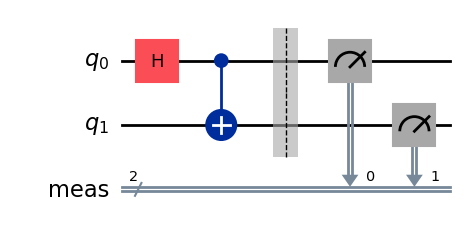

In [3]:
# Create a circuit (uniform superposition state).
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
qc.draw()

In [4]:
# Run circuit using Sampler

sampler = Sampler()
job = sampler.run(qc, shots=1000)
result = job.result()
result

SamplerResult(quasi_dists=[{0: 0.494, 3: 0.506}], metadata=[{'shots': 1000}])

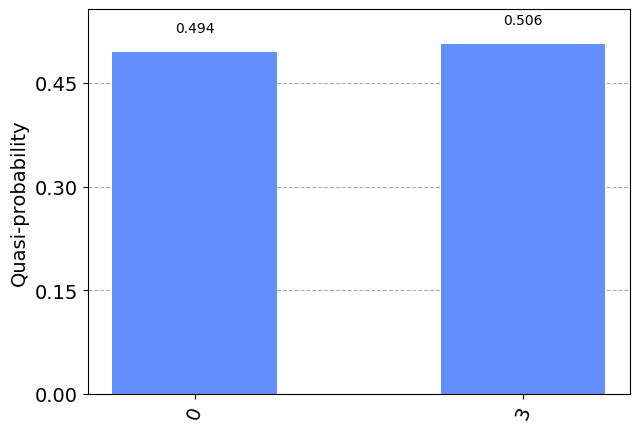

In [5]:
plot_histogram(result.quasi_dists)

## Using Qiskit Runtime

In [ ]:
# If you are running locally (i.e. on your laptop, not on the IBM Quantum Lab), install the qiskit-ibm-runtime package
!pip install qiskit-ibm-runtime -U

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum", instance='pinq-quebec-hub/internal/main')

In [ ]:
# Save account information if you are running locally

service.save_account(channel="ibm_quantum", token="MY_IBM_QUANTUM_TOKEN")

## Service setup and features

In [7]:
# Get available backends

service.backends()

[<IBMBackend('ibm_quebec')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('simulator_statevector')>]

## Qiskit Runtime `Sampler` class

In [8]:
from qiskit_ibm_runtime import Sampler, Options

backend = service.get_backend('ibm_quebec')
print(backend)

options = Options()
options.execution.shots = 1024

qc_t = transpile(qc, backend)

sampler = Sampler(backend=backend, options=options)
job = sampler.run(qc_t)

<IBMBackend('ibm_quebec')>


In [11]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [12]:
result = job.result()
print(result)

SamplerResult(quasi_dists=[{0: 0.404206979777462, 1: 0.013179799956464, 2: -0.008971223519201, 3: 0.591584443785274}], metadata=[{'shots': 1024, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.2561612660963122, 'readout_mitigation_time': 0.07093016430735588}])


## `Estimator` Primitive

Purpose: compute $\langle\psi| O |\psi\rangle$

where $|\psi\rangle$ is a quantum state, and $O$ is an operator representing an observable.

In [13]:
from qiskit.primitives import Estimator

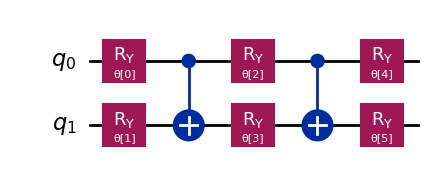

In [14]:
from qiskit.circuit.library import RealAmplitudes

# Create test circuit that has parameterized gates
psi1 = RealAmplitudes(num_qubits=2, reps=2)

psi1.decompose().draw()

In [15]:
# Parameter values for test circuit
theta1 = [0, 1, 1, 2, 3, 5]

In [16]:
from qiskit.quantum_info import SparsePauliOp

# Create observable
H1 = SparsePauliOp.from_list([("II", 1), ("IZ", 2), ("XI", 3)])
print(H1)

SparsePauliOp(['II', 'IZ', 'XI'],
              coeffs=[1.+0.j, 2.+0.j, 3.+0.j])


In [17]:
# calculate [ <psi1(theta1)|H1|psi1(theta1)> ]
estimator = Estimator()
job = estimator.run(circuits=psi1,
                    observables=H1,
                    parameter_values=[theta1]
                   )
psi1_H1_result = job.result()
print(psi1_H1_result)

EstimatorResult(values=array([1.55555728]), metadata=[{}])


In [20]:
from qiskit_ibm_runtime import Estimator

# Run on backend
real_backend = service.get_backend('ibm_quebec')

options = Options()
options.execution.shots = 1024

# Transpile the circuit and map the observable operator to the qubits used by the transpiler
psi1_t = transpile(psi1, backend)
H1_t = H1.apply_layout(psi1_t.layout)

estimator = Estimator(backend=real_backend, options=options)
job = estimator.run(circuits=psi1_t,
                    observables=H1_t,
                    parameter_values=[theta1]
                   )

In [27]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [28]:
psi1_H1_result = job.result()
print(psi1_H1_result)

EstimatorResult(values=array([1.38453959]), metadata=[{'variance': 13.344442877731618, 'shots': 1024, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}])


In [29]:
from qiskit.version import get_version_info as get_qiskit_version_info
from qiskit_ibm_runtime.version import get_version_info as get_runtime_version_info

print(f"Qiskit version: {get_qiskit_version_info()}")
print(f"Qiskit Runtime version: {get_runtime_version_info()}")

Qiskit version: 1.0.2
Qiskit Runtime version: 0.22.0
